In [1]:
import pandas as pd
import numpy as np
import gc

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, \
                            accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
plt.style.use(['default'])
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False,
    'figure.facecolor':'white',
    'font.family': 'serif',
}
plt.rcParams.update(params)

### Read data

In [21]:
dftrain = pd.read_csv('../data/train.csv')
dftest = pd.read_csv('../data/test.csv')

## Exploratory Data Analysis

#### Get domain knowledge

In [4]:
print('Train:\n')
print('Number of rows: {}\nNumber of columns: {}\n'.format(dftrain.shape[0], dftrain.shape[1]))
print('Test:\n')
print('Number of rows: {}\nNumber of columns: {}'.format(dftest.shape[0], dftest.shape[1]))

Train:

Number of rows: 4459
Number of columns: 4993

Test:

Number of rows: 49342
Number of columns: 4992


In [5]:
pd.merge(dftrain.dtypes.sort_values().to_frame('feature_type').groupby('feature_type').size().to_frame('train_count').reset_index(),
         dftest.dtypes.sort_values().to_frame('feature_type').groupby('feature_type').size().to_frame('test_count').reset_index(),
         on='feature_type', how='outer')

,feature_type,train_count,test_count
0,int64,3147,NaN
1,float64,1845,4991.0
2,object,1,1.0


In [6]:
dftrain.head(5)

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [7]:
dftest.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Target price statistics and distributions

In [46]:
dftrain.target.describe().to_frame().reset_index()

,index,target
0,count,4.459000e+03
1,mean,5.944923e+06
2,std,8.234312e+06
3,min,3.000000e+04
4,25%,6.000000e+05
5,50%,2.260000e+06
6,75%,8.000000e+06
7,max,4.000000e+07


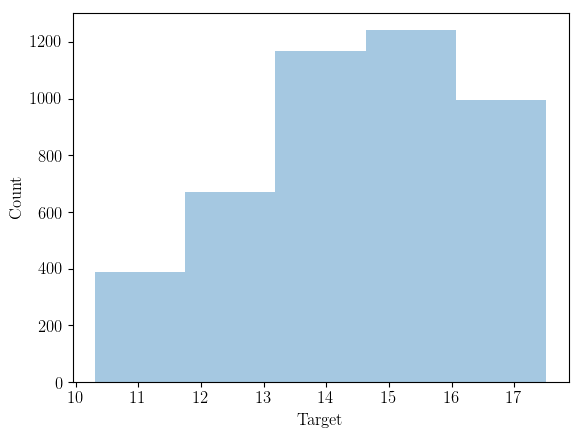

In [47]:
sns.distplot(np.log(dftrain.target), bins= 5, kde = False)
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

### 2. Feature selections and clean

#### Remove missing rows/features

In [8]:
print(dftrain.isnull().sum(axis = 0).to_frame('count').groupby('count').size())
print(dftest.isnull().sum(axis = 0).to_frame('count').groupby('count').size())

count
0    4993
dtype: int64
count
0    4992
dtype: int64


#### Remove constant features

In [22]:
def find_constant_features(dataFrame):
    features_to_remove = []
    for column in list(dataFrame.columns):
        if dataFrame[column].unique().size < 2:
            features_to_remove.append(column)
    return features_to_remove

In [23]:
features_to_remove = find_constant_features(dftrain)

In [24]:
target = dftrain.target
dftrain.drop(['target'], axis = 1, inplace = True)
features_to_remove.append('ID')

dftrain.drop(features_to_remove, axis = 1, inplace = True)
dftest.drop(features_to_remove, axis = 1, inplace = True)

In [25]:
print(dftrain.shape)
print(dftest.shape)

(4459, 4735)
(49342, 4735)


#### Remove Duplicate rows

In [26]:
groups = dftrain.columns.to_series().groupby(dftrain.dtypes).groups

In [27]:
aa = dftrain.columns.to_series().groupby(dftrain.dtypes).groups

#### Remove Duplicate columns

In [15]:
## With the help from :
## https://www.kaggle.com/samratp/lightgbm-xgboost-catboost

# def duplicate_columns(frame):
#     groups = frame.columns.to_series().groupby(frame.dtypes).groups
#     dups = []

#     for t, v in groups.items():

#         cs = frame[v].columns
#         vs = frame[v]
#         lcs = len(cs)

#         for i in range(lcs):
#             ia = vs.iloc[:,i].values
#             for j in range(i+1, lcs):
#                 ja = vs.iloc[:,j].values
#                 if np.array_equal(ia, ja):
#                     dups.append(cs[i])
#                     break

#     return dups

In [331]:
# duplicate_cols = duplicate_columns(dftrain)

In [28]:
duplicate_cols = ['34ceb0081', '8d57e2749', '168b3e5bc', 'a765da8bc', 'acc5b709d']

In [33]:
dftrain.drop(duplicate_cols, axis = 1, inplace = True)
dftest.drop(duplicate_cols, axis = 1, inplace = True)

In [34]:
dftrain.to_csv('../data/cleaned_train.csv')
dftest.to_csv('../data/cleaned_test.csv')